Initialize the enviroment and import the packages

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Read CSV data file

In [3]:
data <- read_csv("data/heart_attack.csv")
data

Rows: 1319 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): class
dbl (8): age, gender, impluse, pressurehight, pressurelow, glucose, kcm, tro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
64,1,66,160,83,160,1.80,0.012,negative
21,1,94,98,46,296,6.75,1.060,positive
55,1,64,160,77,270,1.99,0.003,negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,85,168,104,96,1.24,4.250,positive
54,1,58,117,68,443,5.80,0.359,positive
51,1,94,157,79,134,50.89,1.770,positive


In [27]:
data <- data |>
    mutate(class = as_factor(class))
data <- data |>
    filter(impluse <= 200)
data <- data |>
    mutate(pressure_diff = pressurehight - pressurelow)
data

age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class,pressure_diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
64,1,66,160,83,160,1.80,0.012,negative,77
21,1,94,98,46,296,6.75,1.060,positive,52
55,1,64,160,77,270,1.99,0.003,negative,83
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,85,168,104,96,1.24,4.250,positive,64
54,1,58,117,68,443,5.80,0.359,positive,49
51,1,94,157,79,134,50.89,1.770,positive,78


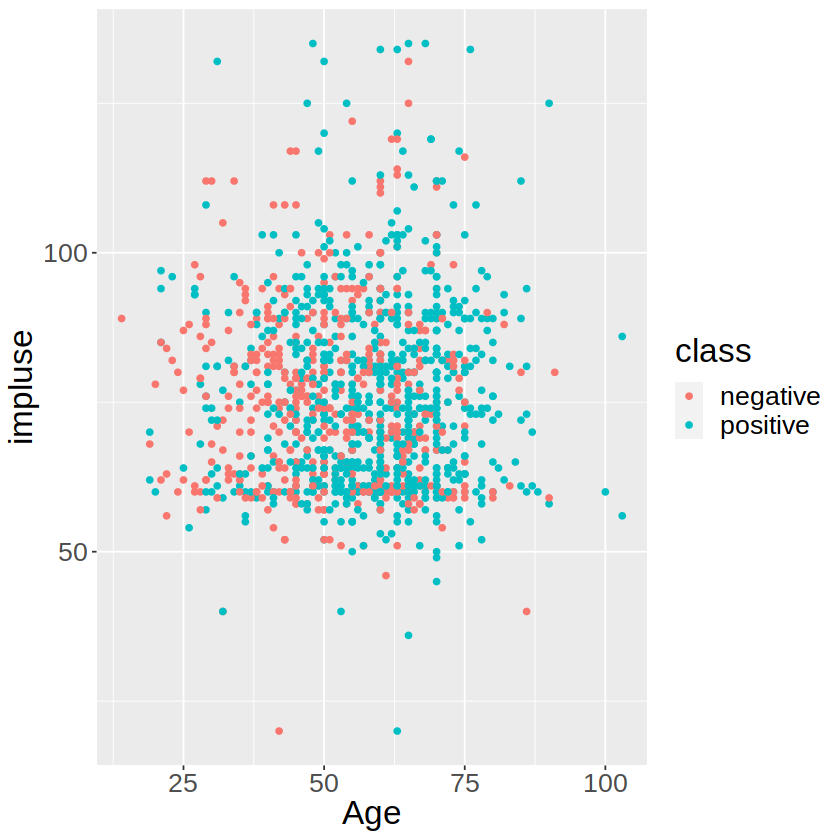

In [14]:
plot <- data |> ggplot(aes(x = age, y = impluse, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("impluse") +
    theme(text = element_text(size=20))
plot

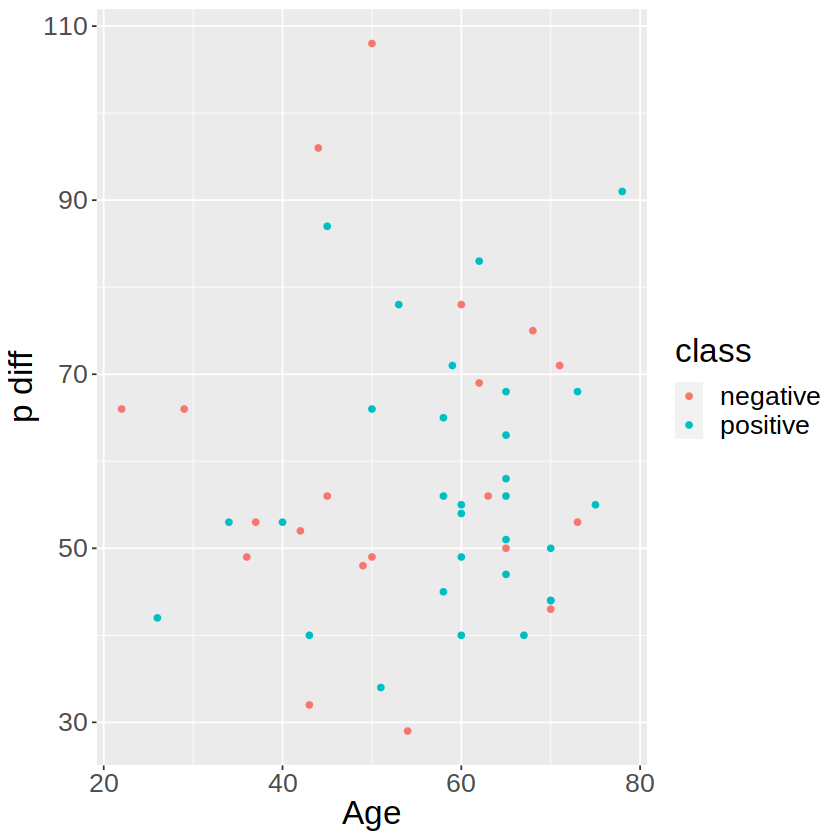

In [36]:
sample_50 <- sample_n(data, 50)
plot_diff <- sample_50 |> ggplot(aes(x = age, y = pressure_diff, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("p diff") +
    theme(text = element_text(size=20))
plot_diff

In [40]:
data_age <- data |>
    group_by(age, class) |>
    summarize(kcm = mean(kcm, na.rm = TRUE))
data_age

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


age,class,kcm
<dbl>,<fct>,<dbl>
14,negative,2.620
19,negative,0.606
19,positive,168.120
⋮,⋮,⋮
91,negative,5.37
100,positive,5.66
103,positive,60.64


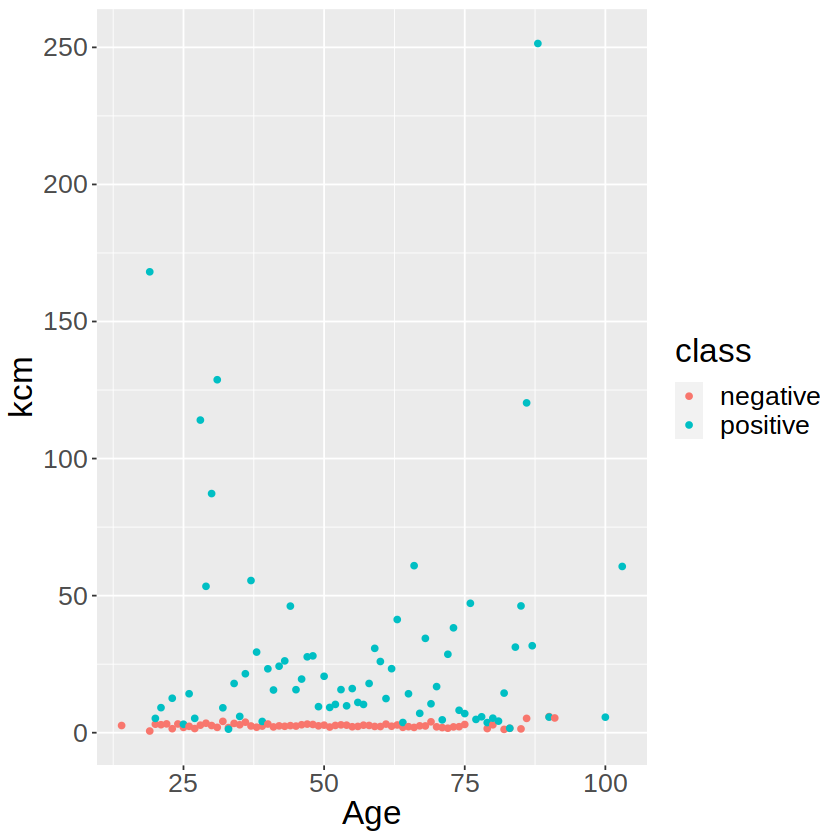

In [42]:
average_plot <- data_age |> ggplot(aes(x = age, y = kcm, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("kcm") +
    theme(text = element_text(size=20))
average_plot

`summarise()` has grouped output by 'kcm'. You can override using the `.groups`
argument.


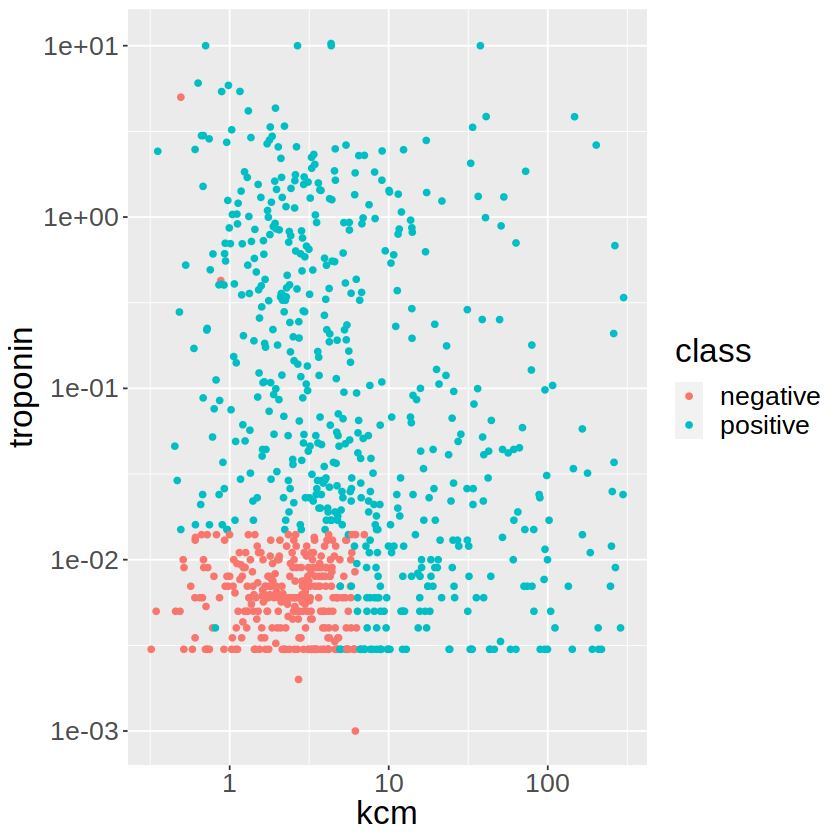

In [53]:
data_kcm <- data |>
    group_by(kcm, class) |>
    summarize(troponin = mean(troponin, na.rm = TRUE))

plot2 <- data_kcm |> ggplot(aes(x = kcm, y = troponin, color = class)) + 
    geom_point() +
    xlab("kcm") + 
    ylab("troponin") +
    scale_x_continuous(trans = 'log10') + 
    scale_y_continuous(trans = 'log10') + 
    theme(text = element_text(size=20))
plot2